In [70]:
initial_path = 'peptide-QML/'
initial_path = '../'

In [71]:
import torch
import torch.nn as nn
import torch.optim as optim

In [72]:
import numpy as np

In [73]:
import sys
sys.path.append(initial_path)

from my_code import functions as f

In [74]:
torch.set_default_dtype(torch.float64)

# Data

In [75]:
file_path = initial_path + 'data/energies/PET/generated/bb14_Strings_Energies_10_000_4_aa.txt'  # Replace with the actual path to your 'data.txt' file
string_list, number_list = f.read_data_file(file_path)
score_list = np.array(number_list)/1000
vector_list = np.array([f.string_to_vector(string) for string in string_list]) # one hot encoding

In [76]:
n_aminoacids = len(string_list[0])

In [77]:
X, Y, X_validation, Y_validation = f.create_validating_set(vector_list, score_list, percentage=0.1)

In [78]:
X = X.reshape(X.shape[0], X.shape[1]*X.shape[2]) # flatten
X_validation = X_validation.reshape(X_validation.shape[0], X_validation.shape[1]*X_validation.shape[2]) # flatten

In [79]:
# Define the dataset
input_data = torch.tensor(X, dtype=torch.float64) 
target_data = torch.tensor(Y, dtype=torch.float64).view(-1, 1)

# Define the validation set
input_validation = torch.tensor(X_validation, dtype=torch.float64)
target_validation = torch.tensor(Y_validation, dtype=torch.float64).view(-1, 1)

# Quantum node

In [80]:
import pennylane as qml

In [81]:
n_qubits = n_aminoacids
n_layers_block = 25
n_layers_embedding = 3
n_shots = 1000
# n_shots = None
dev = qml.device("default.qubit.torch", wires=n_qubits, shots=n_shots)


In [82]:
shape_weights_embedding = (n_layers_embedding, n_qubits, 2)
shape_weights_block_1 = (n_layers_block, n_qubits, 2)
shape_weights_block_2 = (n_layers_block, n_qubits//2, 2)

In [83]:
# size_weights = np.product(shape_weights_embedding) + np.product(shape_weights_block_1) + np.product(shape_weights_block_2)
size_weights = np.product(shape_weights_block_1) + np.product(shape_weights_block_2)

In [84]:
@qml.qnode(dev, interface='torch')
def qnode(inputs, weights):

    weights_block_1 = weights[:np.product(shape_weights_block_1)].reshape(shape_weights_block_1)
    weights_block_2 = weights[np.product(shape_weights_block_1):].reshape(shape_weights_block_2)

    # embedding layer
    qml.AngleEmbedding(inputs, wires=range(n_qubits))

    # # embedding layer
    # for i in range(n_qubits):
    #     qml.RX(inputs[i], wires=i)

    #block
    for i in range(n_layers_block):
        # rotations for each qubit
        for j in range(n_qubits):
            qml.RY(weights_block_1[i,j,0], wires=j)
            qml.RZ(weights_block_1[i,j,1], wires=j)

        # ZZ rotation for neighboring qubits         
        for j in range(0,n_qubits,2): 
            qml.CNOT(wires=[j, (j+1)])

        # rotations for some qubits
        for j, w in enumerate(range(1, n_qubits, 4)): 
            qml.RY(weights_block_2[i,j,0], wires=w)
            qml.RZ(weights_block_2[i,j,1], wires=w)
            qml.RY(weights_block_2[i,j+1,0], wires=w+1)
            qml.RZ(weights_block_2[i,j+1,1], wires=w+1)
            qml.CNOT(wires=[w, (w+1)])

    # measurement
    return [qml.expval(qml.PauliZ(wires=1))]

In [85]:
qnode([1,2,3,4], np.zeros((size_weights,)))

[tensor(-0.2160)]

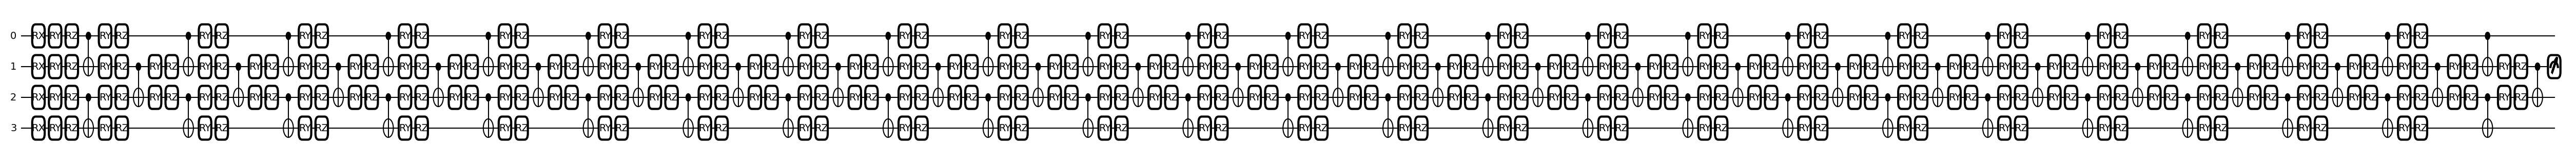

In [86]:
qml.drawer.use_style("black_white")
fig, ax = qml.draw_mpl(qnode, expansion_strategy="device")([i for i in range(n_qubits)], np.zeros((size_weights,)))
fig.set_size_inches((50,3))

In [87]:
weight_shapes = {"weights": (size_weights,)}

In [88]:
qlayer = qml.qnn.TorchLayer(qnode, weight_shapes)

# Hybrid model

In [89]:
input_dim = input_data.size(1)

In [90]:
n_pre_classical_layers = 4
layers_dim = np.linspace(n_qubits, input_dim, 4).astype(int)

In [91]:
layers = []
for i in range(1, len(layers_dim)):
    layers += [nn.Linear(layers_dim[-1*i], layers_dim[-1*(i+1)]), nn.ReLU()]
layers += [nn.Linear(layers_dim[0], layers_dim[0])]
layers += [qlayer]
# layers += [nn.Linear(1, 1)]
# layers += [nn.Linear(2, 4), nn.ReLU()]
# layers += [nn.Linear(4, 1)]


Net = nn.Sequential(*layers)

In [92]:
# Create an instance of the network
model = Net

In [93]:
import time

In [94]:
# input_data[0] to astype('float64')


In [95]:
# time
start_time = time.time()


# Define the loss function and optimizer
criterion = nn.MSELoss()  # Mean Squared Error loss
optimizer = optim.Adam(model.parameters(), lr=0.05)  # Adam optimizer with learning rate 0.001
# optimizer = optim.SGD(model.parameters(), lr=0.05)

# Training loop
num_epochs = 25
batch_size = 32

#validation data
i_validation = input_validation[::10] #we take only 10% of the validation data, to speed up the process
t_validation = target_validation[::10] 

losses = []
losses_epochs = [0]
losses_epochs_validation = [0]

losses_epochs[-1] = criterion(model(input_data), target_data).item()
losses_epochs_validation[-1] = criterion(model(i_validation), t_validation).item()
print('Epoch [{}/{}], Loss: {:.4f}, Loss validation: {:.4f}'.format(0, num_epochs, losses_epochs[-1], losses_epochs_validation[-1]))

for epoch in range(num_epochs):
    # Shuffle the dataset
    indices = torch.randperm(input_data.size(0))
    input_data = input_data[indices]
    target_data = target_data[indices]

    losses_epochs.append(0)

    # Mini-batch training
    for i in range(0, input_data.size(0), batch_size):

        inputs = input_data[i:i+batch_size]
        targets = target_data[i:i+batch_size]

        # Forward pass
        outputs = model(inputs)

        # Compute the loss
        loss = criterion(outputs, targets)

        # Backward pass and optimization
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        # Store the loss
        losses.append(loss.item())

        print('- Epoch [{}/{}], i: [{}/{}], Loss: {:.4f}'.format(epoch+1, num_epochs, i, input_data.size(0), loss.item()), end='\r')

        # add to the epoch loss
        losses_epochs[-1] += loss.item() 

    # divide the epoch loss by the number of batches, to get the average loss
    losses_epochs[-1] /= (input_data.size(0)/batch_size)

    # Validation
    losses_epochs_validation.append(criterion(model(i_validation), t_validation).item()) 

    # print the loss of 3 strings of the validation data
    for i in range(3):
        prediction = model(i_validation[i])
        target = t_validation[i]
        print('\t Validation string, \t i: {}; \t prediction: {:.4f}, \t target: {:.4f}, \t loss: {:.4f}'.format(i, prediction.item(), target.item(), criterion(prediction, target).item()))

    # time
    # Compute elapsed time and remaining time
    elapsed_time = time.time() - start_time
    avg_time_per_epoch = elapsed_time / (epoch + 1)
    remaining_epochs = num_epochs - (epoch + 1)
    estimated_remaining_time = avg_time_per_epoch * remaining_epochs

    # Convert remaining time to hours, minutes, and seconds for better readability
    hours, remainder = divmod(estimated_remaining_time, 3600)
    minutes, seconds = divmod(remainder, 60)

    # Print the loss and remaining time for this epoch
    print('Epoch [{}/{}], Loss: {:.4f}, Loss validation: {:.4f}, Time remaining: ~{}h {}m {:.0f}s'.format(
        epoch+1, num_epochs, losses_epochs[-1], losses_epochs_validation[-1], hours, minutes, seconds))


Epoch [0/25], Loss: 0.0205, Loss validation: 0.0177


RuntimeError: Function ExecuteTapesBackward returned an invalid gradient at index 0 - got [] but expected shape compatible with [32]

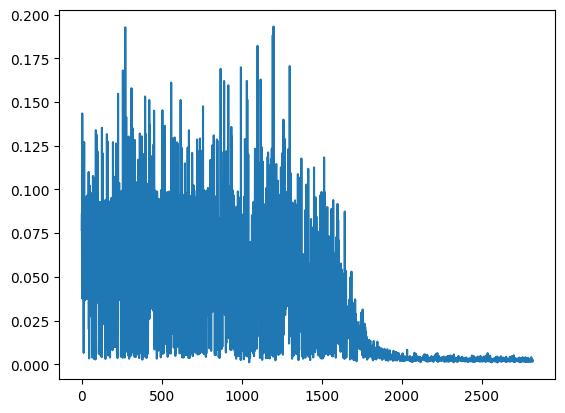

In [ ]:
#plot the loss
import matplotlib.pyplot as plt
plt.plot(losses)
plt.show()

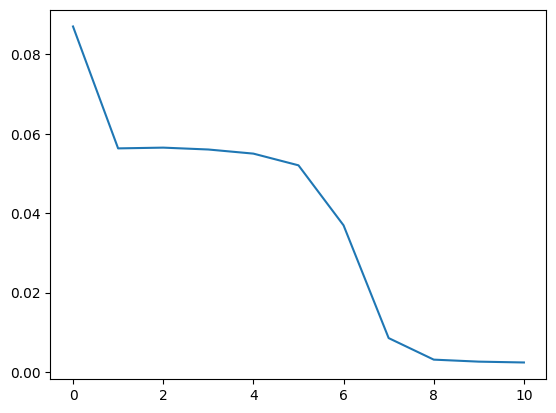

In [ ]:
#plot the loss
import matplotlib.pyplot as plt
plt.plot(losses_epochs)
plt.show()

In [ ]:
avg_loss = 0
for x, (i, t) in enumerate(zip((input_validation), target_validation)):
    loss = criterion(model(i), t)
    avg_loss += loss/len(target_validation)
    print('i: {}, \t target: {:.3f}, \t output: {:.3f}, \t loss: {:.3f}'.format(x, t.item(), model(i).item(), loss))

print('Average loss: {:.3f}'.format(avg_loss))

i: 0, 	 target: -0.007, 	 output: 0.002, 	 loss: 0.000
i: 1, 	 target: -0.197, 	 output: -0.105, 	 loss: 0.008
i: 2, 	 target: 0.964, 	 output: 0.954, 	 loss: 0.000
i: 3, 	 target: 0.919, 	 output: 0.916, 	 loss: 0.000
i: 4, 	 target: -0.146, 	 output: -0.105, 	 loss: 0.002
i: 5, 	 target: -0.044, 	 output: -0.028, 	 loss: 0.000
i: 6, 	 target: -0.122, 	 output: -0.084, 	 loss: 0.001
i: 7, 	 target: -0.093, 	 output: -0.105, 	 loss: 0.000
i: 8, 	 target: -0.044, 	 output: -0.068, 	 loss: 0.001
i: 9, 	 target: -0.150, 	 output: -0.040, 	 loss: 0.012
i: 10, 	 target: -0.131, 	 output: -0.105, 	 loss: 0.001
i: 11, 	 target: -0.067, 	 output: -0.055, 	 loss: 0.000
i: 12, 	 target: -0.127, 	 output: -0.105, 	 loss: 0.000
i: 13, 	 target: -0.142, 	 output: -0.104, 	 loss: 0.001
i: 14, 	 target: -0.072, 	 output: -0.105, 	 loss: 0.001
i: 15, 	 target: -0.131, 	 output: -0.105, 	 loss: 0.001
i: 16, 	 target: -0.144, 	 output: -0.105, 	 loss: 0.001
i: 17, 	 target: -0.108, 	 output: -0.105, 	 l

# Save the Notebook as a PDF

In [ ]:
import subprocess
import os

name_notebook = "0726-small_hybrid_model_1q_measurement_v1.ipynb"  

output_filename = "results/"+ name_notebook[:4] +"/" + name_notebook[:-6] + "_0.pdf"

#check if the output file already exists
while os.path.exists(output_filename):
    print("The file {} already exists".format(output_filename))
    output_filename = output_filename[:-5] + str(int(output_filename[-5]) + 1) + ".pdf"
    print("Trying to save the file as {}".format(output_filename))
    

subprocess.run(["jupyter", "nbconvert", "--to", "pdf", "--output", output_filename, name_notebook])




The file results/0726/0726-small_hybrid_model_1q_measurement_0.pdf already exists
Trying to save the file as results/0726/0726-small_hybrid_model_1q_measurement_1.pdf


CompletedProcess(args=['jupyter', 'nbconvert', '--to', 'pdf', '--output', 'results/0726/0726-small_hybrid_model_1q_measurement_1.pdf', '0726-small_hybrid_model_1q_measurement.ipynb'], returncode=0)